# E4 and Hexoskin Processing Pipeline
Written by Arturo Salinas for the University of Connecticut Human Factors IO Labrotory under the guidance of PI Dr. Insoo Kim

### Import Packages and Set Session Directory

Install the required packages:
Utilize conda where possible, pip where you cannot.
__________________________________
    -   numpy
    -   pandas
    -   matplotlib
    -   ipywidgets
    -   neurokit2
    -   IPython
    -   pyedflib
    -   ipyfilechooser
    -   ipykernel
_____________________


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import neurokit2 as nk
from ipyfilechooser import FileChooser
from IPython.display import display, HTML
from datetime import datetime, timezone
from pyedflib.highlevel import read_edf
from wrangle import *
# from time_loader import *
%matplotlib widget

Checks for the correct data in selected directory

In [3]:
required_files = [
        'CSV.csv',
        'EDF.edf',
        'BVP.csv',
        'EDA.csv',
        'ACC.csv',
        'TEMP.csv',
        'tags.csv',
        'IBI.csv'
    ]

dataDirectory = "C:/home/Sessions/P009/"
participant_id = int(9)
events = "C:/home/Sessions/time_data.csv"

print("Current directory is:", dataDirectory)
missing_files = [f for f in required_files if f not in os.listdir(dataDirectory)]
existing_files = [f for f in os.listdir(dataDirectory) if f in required_files]
if participant_id:
    print(f"\nChecking files for participant: {participant_id}")
    print(f"Directory being checked: {dataDirectory}")
    if not missing_files:
        print("✓ All required files are present!")
    else:
        print("\nMissing files:")
        for file in missing_files:
            print(f"✗ {file}")
        print(f"\nFound files:")
        for file in existing_files:
            print(f"• {file}")

Current directory is: C:/home/Sessions/P009/

Checking files for participant: 9
Directory being checked: C:/home/Sessions/P009/
✓ All required files are present!


# Load Hexoskin Data

In [4]:
hexcsv = os.path.join(dataDirectory, "CSV.csv")
hexedf = os.path.join(dataDirectory, "EDF.edf")

hextable = pd.read_csv(hexcsv)
hextable = hextable.iloc[:, [0, 1, 2, 4, 5, 6]]                            # Keeps time, breathing, minute vent, act, HR, and cadence -AJS
hextable = hextable.iloc[1:-1, :].reset_index(drop=True)                   # Drops first and last rows, resets index -AJS
time_start_hexo = hextable.iloc[0, 0] / 256                                # Gets start time in seconds * ( 1 / 256 as that is the sampling rate of time in csv) -AJS
startTime_hexo = datetime.fromtimestamp(time_start_hexo, tz=timezone.utc)  # Converts timestamp to datetime -AJS

signals, signal_headers, header = read_edf(hexedf)

ECG = signals[0]
HR = signals[1]
BR = signals[2]
RespT = signals[3]
RespA = signals[4]
AccX = signals[11]
AccY = signals[12]
AccZ = signals[13]

Resp = 13.28 * ((0.75 * RespT) + (0.25 * RespA))     # see hexoskin documentation for how this is calculated
ACC_Hex = np.sqrt((AccX**2) + (AccY**2) + (AccZ**2)) # magnitude calculation


## Initial Inspection of Hexoskin Data

In [5]:
# print("EDF Signal Data:")
# for i, signal in enumerate(signals):
#    signal_header = signal_headers[i]
#    channel_name = signal_header['label']
#    sampling_rate = signal_header['sample_frequency']
#    start_time_offset = signal_header.get('start_time', 0) 

#    time_vector = np.array([start_time_offset + (sample_index / sampling_rate) for sample_index in range(len(signal[:3]))])

#    print(f"\nSignal {i}: {channel_name}")
#    print(f"  Sampling Rate: {sampling_rate} Hz")
    
#    print("  Timestamp \t | Data")
#    for j in range(len(signal[:3])):
#    print(f"{time_vector[j]:.4f} s \t | {signal[j]}")

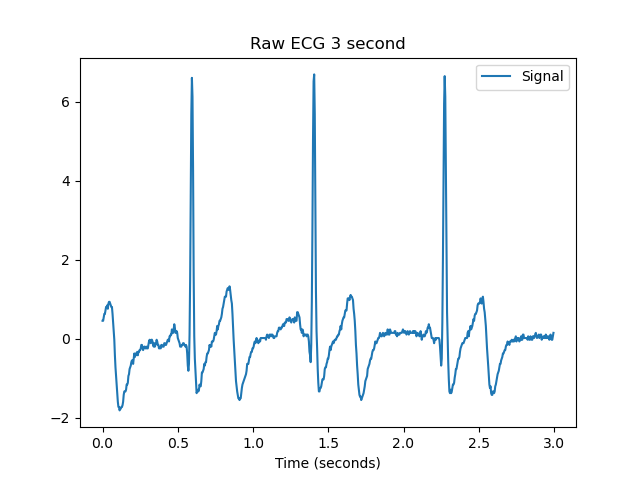

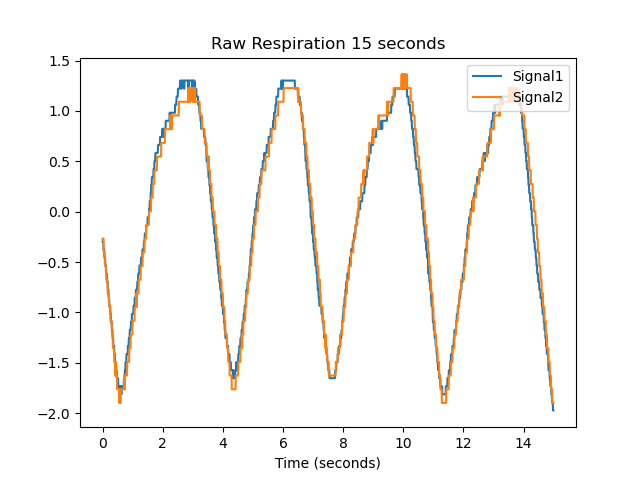

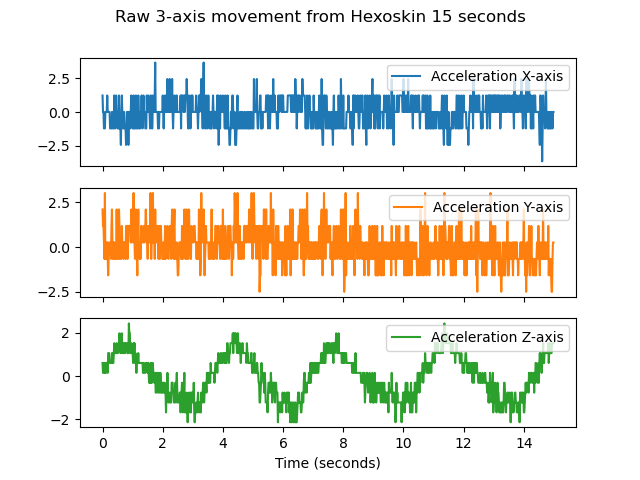

In [6]:
nk.signal_plot(ECG[460800:461568], sampling_rate=256, standardize=True) # ~ 3 second window -AJS
plt.title("Raw ECG 3 second")
nk.signal_plot([RespT[230400:232320], RespA[230400:232320]], sampling_rate=128, standardize=True) # ~ 15 second window -AJS
plt.title("Raw Respiration 15 seconds")
nk.signal_plot([AccX[115200:116160], AccY[115200:116160], AccZ[115200:116160]], sampling_rate=64,
               subplots=True, standardize=True,
               labels=["Acceleration X-axis", "Acceleration Y-axis", "Acceleration Z-axis"]) # ~ 15 second window -AJS
plt.suptitle("Raw 3-axis movement from Hexoskin 15 seconds");

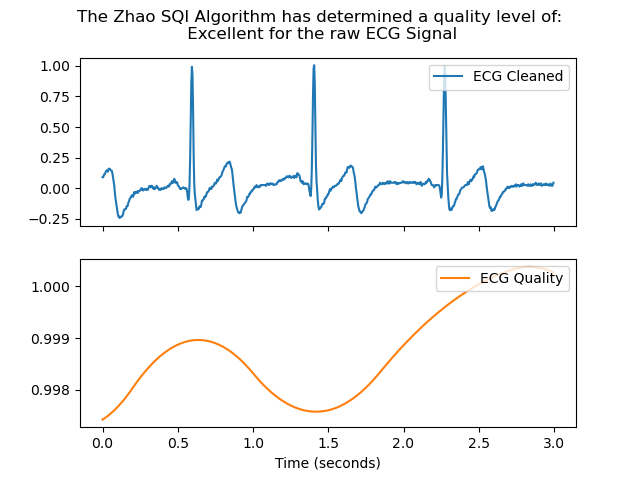

In [7]:
ecg_quality = nk.ecg_quality(ECG, sampling_rate=256, method="averageQRS")

nk.signal_plot(
    [ECG[460800:461568], ecg_quality[460800:461568]],
    sampling_rate=256,
    subplots=True,
    labels=["ECG Cleaned", "ECG Quality"],
    standardize=False
)
plt.suptitle(f"The Zhao SQI Algorithm has determined a quality level of:\n {nk.ecg_quality(ECG, sampling_rate=256, method='zhao2018', approach='fuzzy')} for the raw ECG Signal");

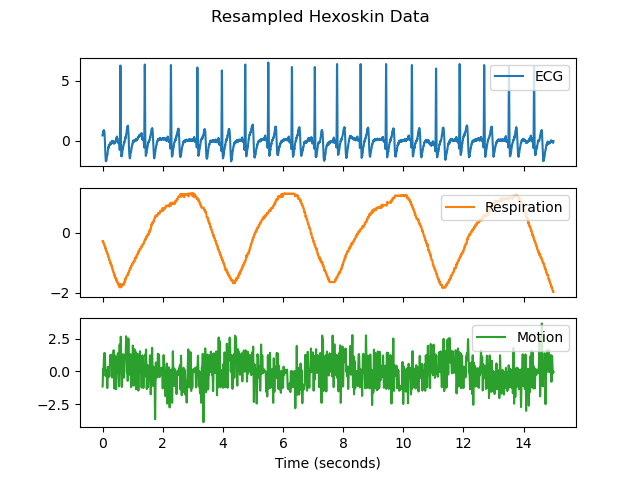

In [8]:
TARGET_SAMPLE_RATE = 256 # just in case we need to downsample instead later... -AJS
fs = TARGET_SAMPLE_RATE
ecg_up = nk.signal_resample(ECG, sampling_rate=256, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT') # already 256 -AJS

RespT_up = nk.signal_resample(RespT, desired_length=len(ECG), sampling_rate=128, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')
RespA_up = nk.signal_resample(RespA, desired_length=len(ECG), sampling_rate=128, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')
Resp_up = nk.signal_resample(Resp, desired_length=len(ECG), sampling_rate=128, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')

hex_accx_up = nk.signal_resample(AccX, desired_length=len(ECG), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='numpy')
hex_accy_up = nk.signal_resample(AccY, desired_length=len(ECG), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='numpy')
hex_accz_up = nk.signal_resample(AccZ, desired_length=len(ECG), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='numpy')
hex_motion_up = nk.signal_resample(ACC_Hex, desired_length=len(ECG), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')

nk.signal_plot([ecg_up[460800:464640], Resp_up[460800:464640], hex_motion_up[460800:464640]], sampling_rate=256, subplots=True, standardize=True, labels=['ECG', 'Respiration', 'Motion'])
plt.suptitle("Resampled Hexoskin Data");

Pack the Hexoskin Signals

In [9]:
hexo_np = np.column_stack([ecg_up, RespT_up, RespA_up, Resp_up, hex_accx_up, hex_accy_up, hex_accz_up, hex_motion_up])

time_index_hexo = pd.date_range(
    start=startTime_hexo,
    periods=len(hexo_np),
    freq=pd.Timedelta(1/fs, unit='s')
)

comb_hexo = pd.DataFrame(
    hexo_np,
    index=time_index_hexo,
    columns=["ECG","Thoratic Respiration", "Abdominal Respiration", "Combined Respiration", "ACC X", "ACC Y", "ACC Z", "Hexoskin Motion"]
)

display(comb_hexo.head())

,ECG,Thoratic Respiration,Abdominal Respiration,Combined Respiration,ACC X,ACC Y,ACC Z,Hexoskin Motion
2024-10-15 17:21:31+00:00,8.947237,1.256280e-11,5.153971e-12,1.937893e-10,-0.515672,-0.226609,-0.527390,0.771628
2024-10-15 17:21:31.003906250+00:00,17.504031,-4.758496e+02,-3.012196e+02,-5.739511e+03,-0.468797,-0.209031,-0.511765,0.810174
2024-10-15 17:21:31.007812500+00:00,17.504031,2.119571e-11,1.059785e-11,1.025640e-10,-0.421922,-0.191453,-0.496140,0.763289
2024-10-15 17:21:31.011718750+00:00,17.504031,7.505359e+02,4.675440e+02,9.027583e+03,-0.375047,-0.173875,-0.480515,0.672684
2024-10-15 17:21:31.015625+00:00,17.504031,2.660738e-11,8.793963e-12,4.571572e-10,-0.328172,-0.156297,-0.464890,0.590126


# Load E4 Data
Loads the data from the E4 CSV's into the notebook environment

In [10]:
BVPe4   = os.path.join(dataDirectory, "BVP.csv")
EDAe4   = os.path.join(dataDirectory, "EDA.csv")
ACCe4   = os.path.join(dataDirectory, "ACC.csv")
Tempe4  = os.path.join(dataDirectory, "TEMP.csv")
HRe4    = os.path.join(dataDirectory, 'HR.csv')   # pre calculated from IBI on empatica side -AJS
IBI_path = os.path.join(dataDirectory, "IBI.csv") # might need this later, but I want to use the hexo ecg instead -AJS   
    
BVP_raw = read_e4_csv(BVPe4, ['bvp']) # 64 Hz
EDA_raw = read_e4_csv(EDAe4, ['eda']) # 4 Hz
ACC_raw = read_e4_csv(ACCe4, ['acc_x', 'acc_y', 'acc_z']) # 32 Hz
Temp_raw = read_e4_csv(Tempe4, ['temp']) # 64 Hz
HRe4_raw = read_e4_csv(HRe4, ['hr_e4']) # 1 Hz
IBIe4 = read_ibi_file(IBI_path) # peak to peak distances from e4 precalced, scaled * 1000 -AJS

# Periods = ["traintest", "rest1", "test1", "rest2", "test2", "rest3", "test3"]

### Initial Inspection of E4 Data

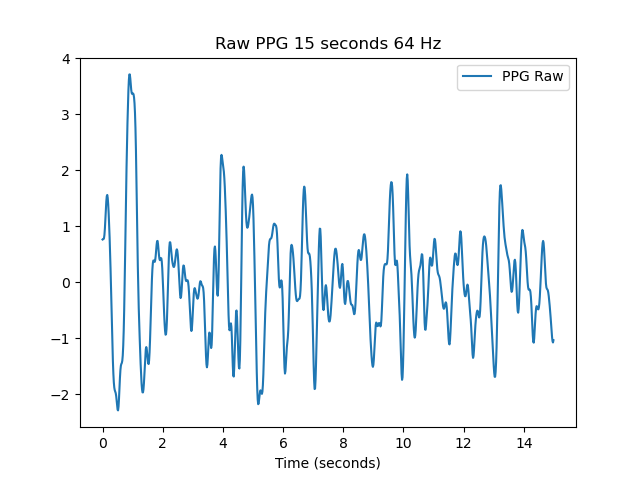

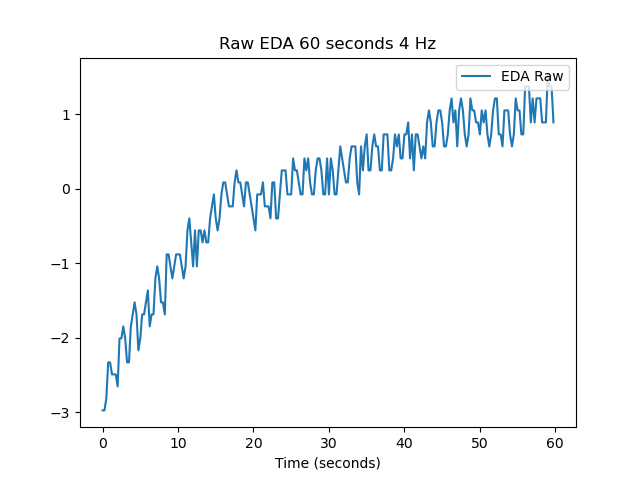

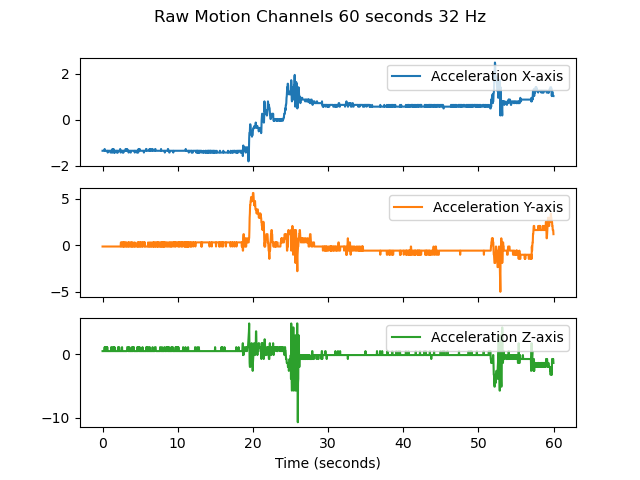

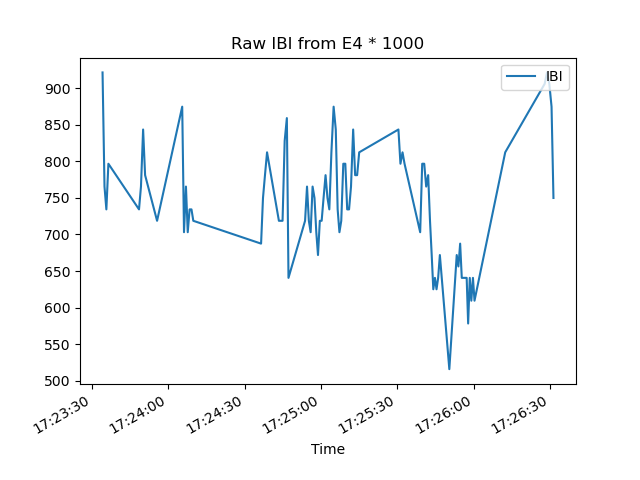

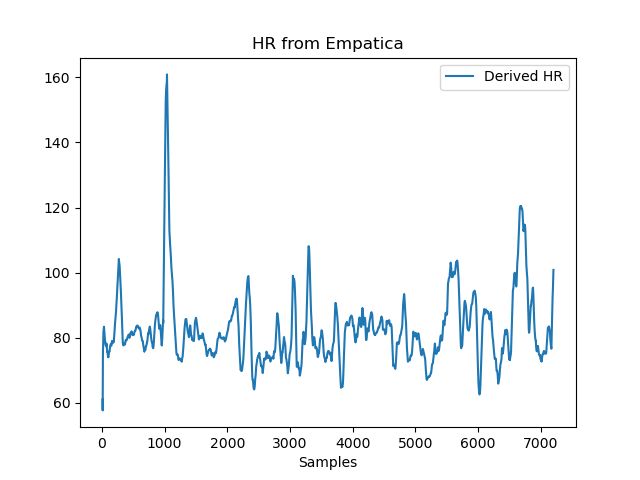

In [11]:
BVP = BVP_raw['bvp'].values
EDA = EDA_raw['eda'].values
acc_x = ACC_raw['acc_x'].values
acc_y = ACC_raw['acc_y'].values
acc_z = ACC_raw['acc_z'].values
Temp = Temp_raw['temp'].values

time_diff = (HRe4_raw.index[0] - BVP_raw.index[0]).total_seconds()

if time_diff > 0:
    buffer = pd.Series([HRe4_raw.iloc[0]] * int(time_diff), index=pd.date_range(
        start=HRe4_raw.index[0] - pd.Timedelta(seconds=time_diff),
        periods=int(time_diff),
        freq="1s"
    ))
    HRe4_raw = pd.concat([buffer, HRe4_raw])

hr_e4 = HRe4_raw['hr_e4'].values

nk.signal_plot(BVP[115200:116160], sampling_rate=64, standardize=True, labels=['PPG Raw']) # ~ 15 second window -AJS
plt.title("Raw PPG 15 seconds 64 Hz")
nk.signal_plot(EDA[7200:7440], sampling_rate=4, standardize=True, labels=['EDA Raw']) # ~ 60 second window -AJS
plt.title("Raw EDA 60 seconds 4 Hz")
nk.signal_plot([acc_x[57600:59520], acc_y[57600:59520], acc_z[57600:59520]], sampling_rate=32,
               subplots=True, standardize=True, 
               labels=["Acceleration X-axis", "Acceleration Y-axis", "Acceleration Z-axis"]) # ~ 15 second window -AJS
plt.suptitle('Raw Motion Channels 60 seconds 32 Hz');
nk.signal_plot(IBIe4[10:100], labels=['IBI'])
plt.title("Raw IBI from E4 * 1000");

nk.signal_plot(hr_e4, labels=['Derived HR'])
plt.title("HR from Empatica");

In [12]:
#acc_x_filt = nk.signal_filter(acc_x, sampling_rate=32, lowcut=0.25, highcut=0.5, method='butterworth', order=3)
#acc_y_filt = nk.signal_filter(acc_y, sampling_rate=32, lowcut=0.25, highcut=0.5, method='butterworth', order=3)
#acc_z_filt = nk.signal_filter(acc_z, sampling_rate=32, lowcut=0.25, highcut=0.5, method='butterworth', order=3)

#nk.signal_plot([acc_x[57600:59520], acc_x_filt[57600:59520]], sampling_rate=32,
#               subplots=False, standardize=True,
#               labels=["Raw X-axis", "Filtered X-axis"])

ACC_E4_raw = np.sqrt((acc_x**2) + (acc_y**2) + (acc_z**2)) # magnitude calculation

# ACC_E4_clean = nk.signal_filter(ACC_E4, sampling_rate=32, highcut=0.5, method='butterworth', order=3)
#nk.signal_plot([ACC_E4[57600:59520], ACC_E4_clean[57600:59520]], sampling_rate=32, labels=['Raw E4 Motion', 'Filtered E4 Motion'], standardize=True)
# plt.suptitle("Motion from E4");

Resample E4 signals to 256
BVP => 64->256 => factor=4, EDA => 4->256 =>64, ACC =>32->256 =>8, Temp =>4->256 =>64

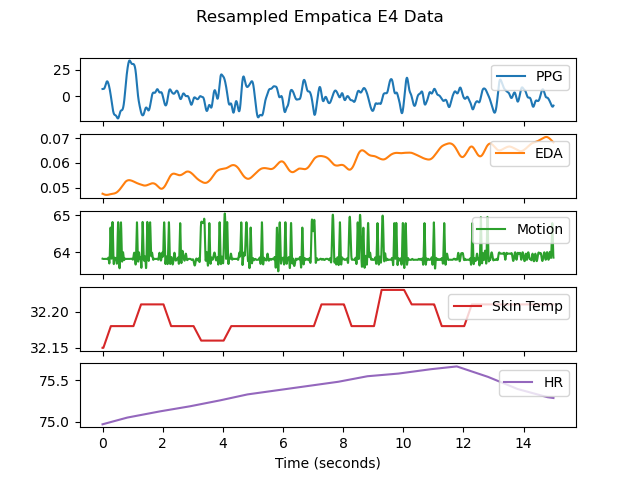

In [13]:
ppg_up = nk.signal_resample(BVP, sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')

#time_bvp = np.arange(len(BVP)) / 64
#time_ppg = np.arange(len(ppg_up)) / 256

#plt.figure()
#plt.plot(time_bvp, BVP, label='Original PPG')
#plt.plot(time_ppg, ppg_up, label='Resampled')
#plt.legend()
#plt.show
eda_up = nk.signal_resample(EDA, desired_length=len(ppg_up), sampling_rate=4, desired_sampling_rate=TARGET_SAMPLE_RATE, method='poly')

#time_eda = np.arange(len(EDA)) / 4
#time_eda_up = np.arange(len(eda_up)) / 256

#plt.figure()
#plt.plot(time_eda, EDA, label='original eda')
#plt.plot(time_eda_up, eda_up, label='upsampled eda')
#plt.legend()
#plt.show

e4_hr_up = nk.signal_resample(hr_e4, desired_length=len(ppg_up), sampling_rate=1, desired_sampling_rate=TARGET_SAMPLE_RATE, method='numpy')

e4_accx_up = nk.signal_resample(acc_x, desired_length=len(ppg_up), sampling_rate=32, desired_sampling_rate=TARGET_SAMPLE_RATE, method='interpolate')
e4_accy_up = nk.signal_resample(acc_y, desired_length=len(ppg_up), sampling_rate=32, desired_sampling_rate=TARGET_SAMPLE_RATE, method='interpolate')
e4_accz_up = nk.signal_resample(acc_z, desired_length=len(ppg_up), sampling_rate=32, desired_sampling_rate=TARGET_SAMPLE_RATE, method='interpolate')
e4_motion_up = nk.signal_resample(ACC_E4_raw, desired_length=len(ppg_up), sampling_rate=32, desired_sampling_rate=TARGET_SAMPLE_RATE, method='interpolate')

temp_up = nk.signal_resample(Temp, desired_length=len(ppg_up), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='numpy')

nk.signal_plot([ppg_up[460800:464640], eda_up[460800:464640], e4_motion_up[460800:464640], temp_up[460800:464640], e4_hr_up[460800:464640]], sampling_rate=256, subplots=True, standardize=False, labels=['PPG', 'EDA', 'Motion', 'Skin Temp', 'HR'])
plt.suptitle("Resampled Empatica E4 Data");

Pack the E4 Signals

In [14]:
e4_np = np.column_stack([ppg_up, eda_up, e4_accx_up, e4_accy_up, e4_accz_up, e4_motion_up, temp_up, e4_hr_up])
startTime_E4 = BVP_raw.index[0] # Highest resolution start time -AJS

time_index_e4 = pd.date_range(
    start=startTime_E4,
    periods=len(e4_np),
    freq=pd.Timedelta(1/fs, unit='s')
)

comb_e4 = pd.DataFrame(
    e4_np,
    index=time_index_e4,
    columns=["PPG", "EDA", "E4 ACC X", "E4 ACC Y", "E4 ACC Z", "Motion E4", "Skin Temp", "Heart Rate"]
)

# Data Alignment

In [15]:
time_data = load_event_data(events)
participant_events = select_participant(time_data, participant_id)
times, utc_times = time_extract(participant_events)

In [16]:
utc_times_df = pd.DataFrame(utc_times)
start_time = pd.to_datetime(utc_times_df['survey_start'].iloc[0]).tz_localize('UTC')
end_time = pd.to_datetime(utc_times_df['recovery_end'].iloc[0]).tz_localize('UTC')

exclude_columns = [
    "date",
    "start_time",
    "end_time",
    "participant_id",
    "total_time",
    "experimental_time",
    "arrival_time"
]

for column in utc_times_df.columns:
    if column not in exclude_columns:
        utc_times_df[column] = pd.to_datetime(utc_times_df[column]).dt.tz_localize('UTC')
        
time_periods = [
    {"name": "survey", "start": utc_times_df['survey_start'].iloc[0], "end": utc_times_df['survey_end'].iloc[0]},
    {"name": "cycle_cal", "start": utc_times_df['cycle_cal_start'].iloc[0], "end": utc_times_df['cycle_cal_end'].iloc[0]},
    {"name": "matb_train", "start": utc_times_df['matb_train_start'].iloc[0], "end": utc_times_df['matb_train_end'].iloc[0]},
    {"name": "cycle", "start": utc_times_df['cycle_start'].iloc[0], "end": utc_times_df['cycle_end'].iloc[0]},
    {"name": "rest_1", "start": utc_times_df['rest_1_start'].iloc[0], "end": utc_times_df['rest_1_end'].iloc[0]},
    {"name": "baseline", "start": utc_times_df['base_start'].iloc[0], "end": utc_times_df['base_end'].iloc[0]},
    {"name": "trial_1", "start": utc_times_df['trial_1_start'].iloc[0], "end": utc_times_df['trial_1_end'].iloc[0]},
    {"name": "rest_2", "start": utc_times_df['rest_2_start'].iloc[0], "end": utc_times_df['rest_2_end'].iloc[0]},
    {"name": "trial_2", "start": utc_times_df['trial_2_start'].iloc[0], "end": utc_times_df['trial_2_end'].iloc[0]},
    {"name": "recovery", "start": utc_times_df['recovery_start'].iloc[0], "end": utc_times_df['recovery_end'].iloc[0]},
    {"name": "debrief", "start": utc_times_df['debrief_start'].iloc[0], "end": utc_times_df['debrief_end'].iloc[0]}
]

#display(comb_e4.head())
#display(comb_hexo.head())
#display(comb_e4.tail())
#display(comb_hexo.tail())

In [17]:
frequency = f"{1000000000 / 256}ns"
experiment_time_index = pd.date_range(start=start_time, end=end_time, freq=frequency)

aligned_e4 = comb_e4.reindex(experiment_time_index)
aligned_hexo = comb_hexo.reindex(experiment_time_index)
# aligned_ibi = IBIe4.reindex(experiment_time_index)

combined_df = pd.concat([aligned_e4, aligned_hexo], axis=1)

display(combined_df.head())
time_periods_df = pd.DataFrame(time_periods)

display(time_periods_df)

,PPG,EDA,E4 ACC X,E4 ACC Y,E4 ACC Z,Motion E4,Skin Temp,Heart Rate,ECG,Thoratic Respiration,Abdominal Respiration,Combined Respiration,ACC X,ACC Y,ACC Z,Hexoskin Motion
2024-10-15 17:28:00+00:00,3.090000,0.144655,8.0,-3.0,64.0,64.566591,34.47,91.903244,0.012844,25521.000000,14010.000000,300702.360000,-1.007859,0.003859,-0.066453,1.010055
2024-10-15 17:28:00.003906250+00:00,3.273805,0.144747,8.0,-3.0,64.0,64.577639,34.47,91.901525,0.006444,25521.038387,14010.272208,300703.646063,-1.007859,0.002883,-0.064500,1.011084
2024-10-15 17:28:00.007812500+00:00,3.462001,0.144827,8.0,-3.0,64.0,64.599166,34.47,91.899806,0.019244,25521.000000,14010.000000,300702.360000,-1.007859,0.001906,-0.062547,1.011417
2024-10-15 17:28:00.011718750+00:00,3.651686,0.144904,8.0,-3.0,64.0,64.623536,34.47,91.898087,0.012844,25521.426121,14009.811275,300705.977597,-1.007859,0.000930,-0.060594,1.010869
2024-10-15 17:28:00.015625+00:00,3.840000,0.144981,8.0,-3.0,64.0,64.643111,34.47,91.896368,0.012844,25522.000000,14010.000000,300712.320000,-1.007859,-0.000047,-0.058641,1.009564


,name,start,end
0,survey,2024-10-15 17:28:00+00:00,2024-10-15 17:31:00+00:00
1,cycle_cal,2024-10-15 17:33:00+00:00,2024-10-15 17:41:30+00:00
2,matb_train,2024-10-15 17:46:05+00:00,2024-10-15 17:58:00+00:00
3,cycle,2024-10-15 17:58:30+00:00,2024-10-15 18:03:30+00:00
4,rest_1,2024-10-15 18:04:35+00:00,2024-10-15 18:14:35+00:00
5,baseline,2024-10-15 18:17:42+00:00,2024-10-15 18:25:50+00:00
6,trial_1,2024-10-15 18:31:39+00:00,2024-10-15 18:39:40+00:00
7,rest_2,2024-10-15 18:42:50+00:00,2024-10-15 06:51:45+00:00
8,trial_2,2024-10-15 18:54:28+00:00,2024-10-15 19:02:28+00:00
9,recovery,2024-10-15 19:06:30+00:00,2024-10-15 19:21:30+00:00


## Unified Data Plots

In [18]:
#plot_signals(combined_df, 'baseline', time_periods, title="Baseline Period", exclude_columns=excluded_columns)
#plot_signals(combined_df, 'trial_1', time_periods, title="Trial Period 1", exclude_columns=excluded_columns)
#plot_signals(combined_df, 'trial_2', time_periods, title="Trial Period 2", exclude_columns=excluded_columns)
excluded_columns = [
    'E4 ACC X', 'E4 ACC Y', 'E4 ACC Z', 'ACC X', 'ACC Y', 'ACC Z',
    'Thoratic Respiration', 'Abdominal Respiration' 
] # for later in the script. -AJS
segment_dropdown = widgets.Dropdown(
    options=[period['name'] for period in time_periods],
    description='Select Segment:',
    disabled=False,
)

plot_button = widgets.Button(
    description='Plot Segment',
    disabled=False,
    button_style='',
    tooltip='Click to plot the selected segment',
    icon='check'
)

output = widgets.Output()

def plot_selected_segment(segment_name):
    with output:
        output.clear_output()
        plot_signals(combined_df, segment_name, time_periods, title=f"{segment_name.capitalize()} Period", exclude_columns=excluded_columns)

def on_button_click(b):
    plot_selected_segment(segment_dropdown.value)

plot_button.on_click(on_button_click)

display(segment_dropdown, plot_button, output)

Dropdown(description='Select Segment:', options=('survey', 'cycle_cal', 'matb_train', 'cycle', 'rest_1', 'base…

Button(description='Plot Segment', icon='check', style=ButtonStyle(), tooltip='Click to plot the selected segm…

Output()

## Pickling of The Synched Data

In [19]:
combined_df.to_pickle(os.path.join(dataDirectory, "synched_data.pkl.gz"), compression="gzip")
time_periods_df.to_pickle(os.path.join(dataDirectory, "event_times.pkl.gz"), compression="gzip")

Well done! 
